In [509]:
import numpy as np
import pandas as pd
import seaborn as sns
import MDAnalysis as mda
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
from MDAnalysis.lib.nsgrid import FastNS
import tqdm.auto as tqdm
from MDAnalysis.lib.distances import calc_angles
from MDAnalysis.lib.distances import calc_bonds
from joblib import Parallel, delayed
from numba import njit
import matplotlib.pyplot as plt

In [ ]:
u = mda.Universe("/home/dibyendu/Cage_Calculation/Systems/273k1bar/run1/npt1.gro",
             "/home/dibyendu/Cage_Calculation/Systems/273k1bar/run1/npt1.xtc")

In [225]:
liq = mda.Universe("/home/dibyendu/DM_Projects/Sample_Structures/Ice/liquid.gro", reset_offset = True)

In [537]:
ih = mda.Universe("/home/dibyendu/DM_Projects/Sample_Structures/Ice/ice1h.gro", reset_offset = True)
ic = mda.Universe("/home/dibyendu/DM_Projects/Sample_Structures/Ice/cs2.gro", reset_offset = True)

In [227]:
hbondsih = HBA(
  universe=ih,
  donors_sel='resname SOL and name OW',
  hydrogens_sel='resname SOL and name HW1 HW2',
  acceptors_sel='resname SOL and name OW',
  d_h_a_angle_cutoff=150,
  d_h_cutoff=1.2,
  d_a_cutoff=3.5,
)
hbondsih.run(verbose = True)

  0%|          | 0/1 [00:00<?, ?it/s]

/home/dibyendu/Soft/anaconda3/envs/Torch/lib/python3.10/site-packages/MDAnalysis/analysis/base.py:438: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time


In [538]:
hbondsic = HBA(
  universe=ic,
  donors_sel='resname ICE and name OW',
  hydrogens_sel='resname ICE and name HW1 HW2',
  acceptors_sel='resname ICE and name OW',
  d_h_a_angle_cutoff=150,
  d_h_cutoff=1.2,
  d_a_cutoff=3.5,
)
hbondsic.run(verbose = True)

  0%|          | 0/1 [00:00<?, ?it/s]

/home/dibyendu/Soft/anaconda3/envs/Torch/lib/python3.10/site-packages/MDAnalysis/analysis/base.py:438: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time


In [228]:
hbondsliq = HBA(
  universe=liq,
  donors_sel='resname SOL and name OW',
  hydrogens_sel='resname SOL and name HW1 HW2',
  acceptors_sel='resname SOL and name OW',
  d_h_a_angle_cutoff=150,
  d_h_cutoff=1.2,
  d_a_cutoff=3.5,
)
hbondsliq.run(verbose = True)

  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Density'>

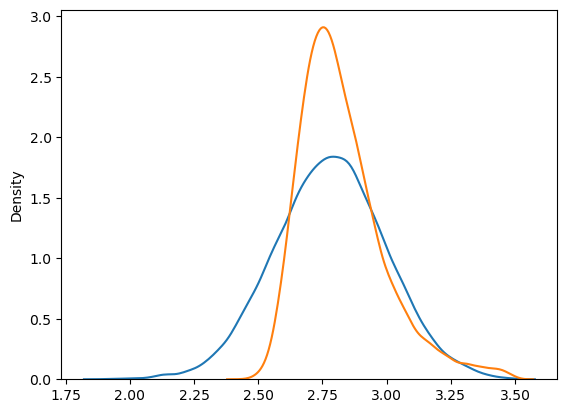

In [230]:
sns.kdeplot(hbondsih.results['hbonds'][:,4])
sns.kdeplot(hbondsliq.results['hbonds'][:,4])

In [510]:
@njit
def localHBs(tid, data):
    nd = data[(data[:,1] == tid) | (data[:,3] == tid)]
    data1 = nd[:,1]
    data2 = nd[:,3]
    return data1, data2

In [489]:
@njit
def neighbour(tid, arr):
    return np.array(list(arr[arr[:,0] == tid][:,1]) + list(arr[arr[:,1] == tid][:,0]))

In [519]:
@njit
def localHBsInfo(tid, arr,hbonds, posi):
    arr_neighbour = neighbour(tid, arr)
    #arr_neighbour = neighbours(tid, arr)
    h_neighbour = 4*arr_neighbour

    my_list = []
    dt = np.column_stack(localHBs(tid, hbonds)).astype(np.int32)
    for data in dt:
        my_list.append(data)
    for nns in h_neighbour:
        list_pair = np.column_stack(localHBs(nns,hbonds)).astype(np.int32)
        for pair in list_pair:
            if arrayChacker(my_list, pair):
                d1 = np.linalg.norm(posi[tid] - posi[pair[0]])
                d2 = np.linalg.norm(posi[tid] - posi[pair[1]])
                if d1 < 5.0 and d2 < 5.0:

                    my_list.append(pair)
            
    return my_list

In [520]:
@njit
def arrayChacker(datalist, pair):
    for data in datalist:
        if (data == pair).all():
            return True
    return False

In [521]:
def localHBDistribution(universe, hbond_obj) :
    pos = universe.select_atoms("name OW").positions
    posi = universe.select_atoms("all").positions
    cutoff = 3.6 
    
    gridsearch = FastNS(cutoff, pos, universe.dimensions, pbc=True)

    results = gridsearch.self_search()
    arr = results.get_pairs()
    hbih_nums = Parallel(n_jobs=-1, backend = "threading")(delayed(localHBsInfo)(i*4,arr,hbond_obj, posi) for i in tqdm.trange(len(pos)))
    number_list = list(map(lambda x : len(set(tuple(i) for i in x)), hbih_nums))
    return np.array(number_list)

In [522]:
hbih_nums = localHBDistribution(ih, hbondsih.results.hbonds)

  0%|          | 0/11664 [00:00<?, ?it/s]

In [523]:
hbliq_nums = localHBDistribution(liq, hbondsliq.results.hbonds)

  0%|          | 0/11222 [00:00<?, ?it/s]

In [539]:
hbic_nums = localHBDistribution(ic, hbondsic.results.hbonds)

  0%|          | 0/13600 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Density'>

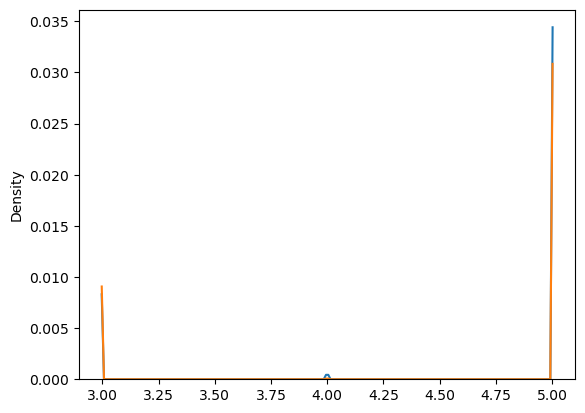

In [546]:
#sns.kdeplot(hbliq_nums, bw_method=0.5)
sns.kdeplot(hbih_nums, bw_method = 0.01)
sns.kdeplot(hbic_nums, bw_method = 0.01)
#plt.xlim([4.9, 5.1])